选择动作使用dqn，使用target_dqn获取所选动作的值

In [1]:
import os
import gym
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from IPython.display import clear_output
from torch.nn.utils import clip_grad_norm_

In [2]:
class ReplayBuffer:
    def __init__(self, column, max_size, batch_size):
        self.current_state = np.zeros((max_size, column), dtype=np.float32)
        self.next_state = np.zeros((max_size, column), dtype=np.float32)
        self.action = np.zeros(max_size, dtype=np.float32)
        self.reward = np.zeros(max_size, dtype=np.float32)
        self.done = np.zeros(max_size,dtype=np.float32)
        self.max_size, self.batch_size = max_size, batch_size
        self.size, self.current_index = 0, 0
    
    def store(self, current_state, action, next_state, reward, done):
        self.current_state[self.current_index] = current_state
        self.action[self.current_index] = action
        self.next_state[self.current_index] = next_state
        self.reward[self.current_index] = reward
        self.done[self.current_index] = done
        self.current_index = (self.current_index + 1) % self.max_size
        self.size = min(self.size + 1, self.max_size)
    
    def sample_batch(self):
        ptr = np.random.choice(self.size, self.batch_size)
        return dict(current_state=self.current_state[ptr],
                    next_state=self.next_state[ptr],
                    action=self.action[ptr],
                    reward=self.reward[ptr],
                    done=self.done[ptr]
        )
    
    def __len__(self):
        return self.size

In [3]:
class Network(nn.Module):
    def __init__(self, in_dim, out_dim):
        super(Network, self).__init__()
        
        self.layers = nn.Sequential(
            nn.Linear(in_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, out_dim)
        )
    def forward(self,x):
        return self.layers(x)

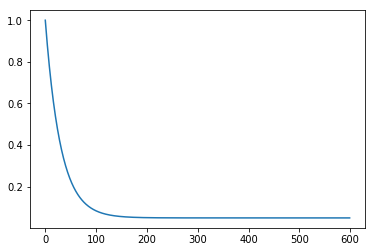

In [4]:
min_epsilon = 0.05
max_epsilon = 1
epsilon_decay = 30
epsilon_episode = lambda episode : min_epsilon + np.exp(-episode / epsilon_decay)*0.95
plt.plot([epsilon_episode(x) for x in range(600)])

In [5]:
env = gym.make('CartPole-v1')

seed = 777

def seed_torch(seed):
    torch.manual_seed(seed)
    if torch.backends.cudnn.enabled:
        torch.backends.cudnn.benchmark = False
        torch.backends.cudnn.deterministic = True

np.random.seed(seed)
seed_torch(seed)
env.seed(seed)        

batch_size = 32
max_size = 1000
memory = ReplayBuffer(env.observation_space.shape[0], max_size, batch_size)

device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

network = Network(env.observation_space.shape[0],env.action_space.n).to(device)
target_network = Network(env.observation_space.shape[0],env.action_space.n).to(device)
target_network.load_state_dict(network.state_dict())
target_network.eval()#把train设置为false，默认为true。可通过target_network.train()将train设置回true

optimizer = optim.Adam(network.parameters(), lr=1e-2)

gamma = 0.99
target_update = 200

In [6]:
def select_action(episode, state):
    if np.random.random_sample() > epsilon_episode(episode):
        selected_action = network(torch.FloatTensor(state).to(device)).argmax().detach().cpu().numpy()
    else:
        selected_action = env.action_space.sample()
    return selected_action

In [7]:
def train():
    samples = memory.sample_batch()
    state = torch.FloatTensor(samples["current_state"]).to(device).to(device)
    next_state = torch.FloatTensor(samples["next_state"]).to(device)
    action = torch.LongTensor(samples["action"].reshape(-1, 1)).to(device)#LongTensor
    reward = torch.FloatTensor(samples["reward"].reshape(-1, 1)).to(device)
    done = torch.FloatTensor(samples["done"].reshape(-1, 1)).to(device)
    
    #main changes
    current_Q_value = network(state).gather(1, action)
    next_action = network(next_state).argmax(1, keepdim=True)
    next_Q_value = target_network(next_state).gather(1,next_action).detach()
    
    target = (reward + gamma*next_Q_value*(1 - done)).to(device)
    loss = ((target - current_Q_value).pow(2)).mean()
    optimizer.zero_grad()
    loss.backward()
    clip_grad_norm_(network.parameters(),1.0,norm_type=1) # Gradient clipping(增加稳定性)
    optimizer.step()
    return loss.item()

In [8]:
def plot_reward(frame_idx, rewards, losses):
    clear_output(True)
    plt.figure(figsize=(18,10))
    plt.subplot(211)
    plt.title('frame %s. mean_reward: %s'%(frame_idx, np.mean(rewards[-10:])))
    plt.plot(rewards)
    plt.xlabel('epoch')
    plt.ylabel('reward')
    plt.subplot(212)
    plt.plot(losses)
    plt.ylabel('loss')
    plt.show()

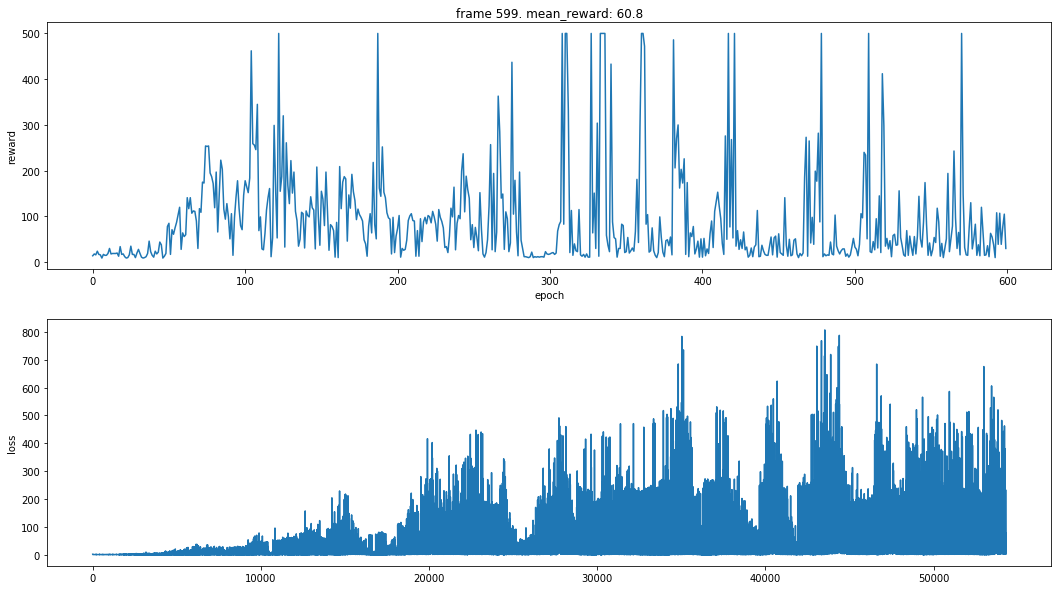

CPU times: user 5min 2s, sys: 8.06 s, total: 5min 10s
Wall time: 5min 39s


In [9]:
%%time
all_rewards = []
losses = []
update_count = 0

for episode in range(600):
    state, rewards = env.reset(), 0
    for i in range(10000):
        action = select_action(episode, state)
        next_state, reward, done, _ = env.step(action)
        memory.store(state, action, next_state, reward, done)
        state = next_state
        rewards += reward
        if done:
            break
        if len(memory) > batch_size:
            loss = train()
            update_count += 1
            losses.append(loss)
            if update_count % target_update == 0:
                target_network.load_state_dict(network.state_dict())     
    all_rewards.append(rewards)
plot_reward(episode,all_rewards,losses)